In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from src.mssm.models import *
np.set_printoptions(suppress=True)

## semi-Markov switching GAMMs

This is an example of the most general models that can be estimated with ``mssm``: A semi-Markov switching Generalized additive mixed model. Such a model is essentially a GAMM in which the (shape) of the relationship between predictors and our signal can differ depending on the state of a latent semi-markov process that develops over time. Additionally, random effects can also differ per stage. Finally, the scale parameter of the GAMM family (sigma in the Gaussian case) can also differ per stage.

An accessible introduction to Markov switching GAMs is provided by Langrock et al., 2017. Haji-Maghsoudi et al., 2021 discuss how semi-Markov switching Generalized linear mixed models can be estimated. They sample random effects in addition to state sequences. Because we exploit the link between smoothing penalties and random effect variance terms (Wood, 2017) we don't need such an extra step.

In [2]:
# Initializing function - basically just sample from a HsMM with the intialized
# parameters.
def prop_states_init(n_t,n_j,pi,T,ps):
   state_durs = []
   states = []

   # Select first state based on pi - initial state distribution
   c_state = np.random.choice(list(range(n_j)))

   # Duration of state is then sampled (at every transition independently!)
   # from the sojourn time distribution of the selected state.
   c_dur = min(int(ps[c_state].rvs()),n_t)
   
   state_durs.append([c_state,c_dur])

   # We remain in that state for duration c_dur
   for _ in range(c_dur):
      states.append(c_state)

   t = c_dur

   # Now we transition!
   while t < n_t:
      remaining_j = list(range(n_j))
      
      # Pick the next state based on it's row in T - the transition
      # probabilities
      c_state = np.random.choice(remaining_j,p=T[c_state,:])

      # Then repeat.
      c_dur = min(int(ps[c_state].rvs()),n_t)

      if t + c_dur > n_t:
         c_dur -= (t + c_dur - n_t)
      
      state_durs.append([c_state,c_dur])

      for _ in range(c_dur):
          states.append(c_state)

      t += c_dur

   return np.array(state_durs), np.array(states)

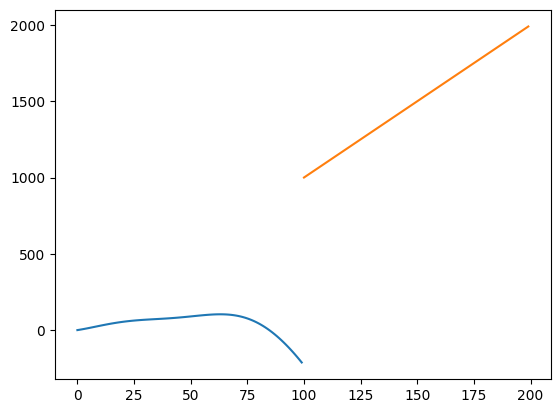

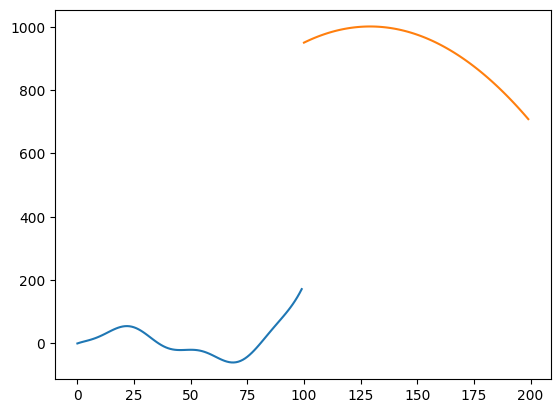

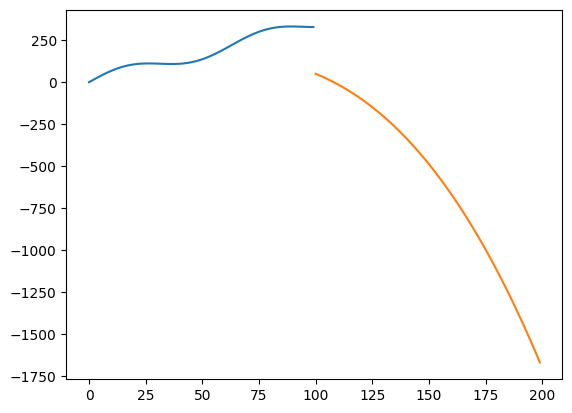

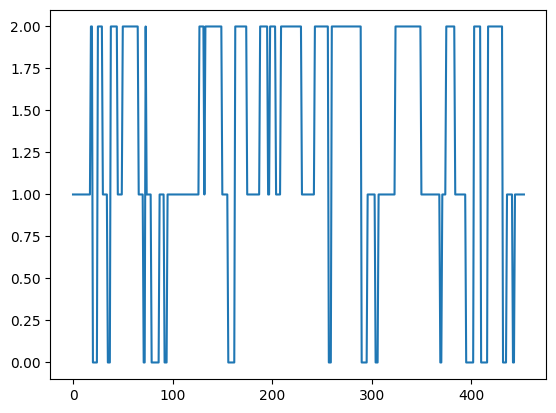

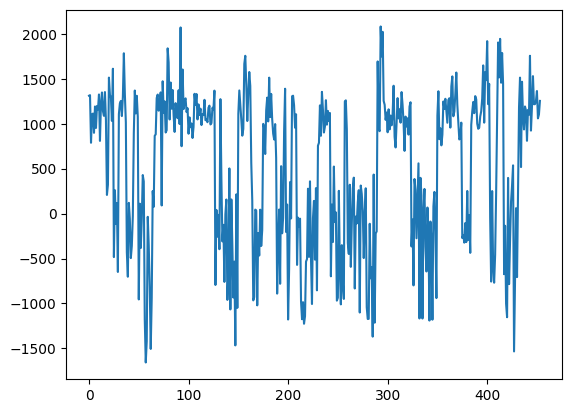

32


In [3]:
# Sim from a sms GAMM with multiple covariates and random intercepts.
# Basically like the initializer but this time we also simulate covariates
# and then the response variable according to some function of the covariates
# that can differ per state!
# Then we also simulate some random intercepts for every series we simulate.
n_s = 20

# Simulation parameters
scales = [2,5,7]
scales_b = [3,4,9]

pi = [0.1,0.7,0.2]

sds = [150,150,150]

rand_sds = [300,450,200]

rand_ints = np.array([scp.stats.norm.rvs(loc=0,scale=rand_sds[j],size=n_s) for j in range(len(rand_sds))])

T = np.array([[0.0,0.7,0.3],
              [0.4,0.0,0.6],
              [0.3,0.7,0.0]])

n_transitions = 50

# Covariates
x = np.array(list(range(100)))
z = np.array(list(range(100,200)))

t_states = []
t_state_durs = []
t_endpoints= []
t_cov = [[],[],[]]
t_time = []
t_y = []
cond = []

# The relationships between y and x,z for every state!
plt.plot(x, 0.3*x + 0.1*x**2 - 0.00125*x**3 + 20*np.sin(x* 10/100))
plt.plot(z, 10*z)
plt.show()

plt.plot(x, 5.5*x - 0.2*x**2 + 0.0015*x**3 + 0.0000015*x**4 + -15*np.sin(x* 20/100))
plt.plot(z, 15.5*z - 0.06*z**2)
plt.show()

plt.plot(x, 3.5*x + 40*np.sin(x* 10/100))
plt.plot(z, 3.5*z - 0.0003*z**3)
plt.show()

for s in range(n_s):

    c = "a"
    c_scales = scales
    if np.random.rand() >= 0.5:
        c = "b"
        c_scales = scales_b
    
    states = []
    state_durs = []
    cov = []
    time = []
    y = []

    t = 0

    c_state = np.random.choice([0,1,2],p=pi)
    c_dur = int(scp.stats.gamma.rvs(a=2, scale=c_scales[c_state],size=1)[0]+0.5)
    state_durs.append([c_state,c_dur])
    for d in range(c_dur):
        states.append(c_state)
        time.append(t)
        c_cov_x = np.random.choice(x,size=1)[0]
        c_cov_z = np.random.choice(z,size=1)[0]
        cov.append([c_cov_x,c_cov_z,s])

        if c_state == 0:
            c_y = 60+0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
            if c == "b":
                c_y += 20*np.sin(c_cov_x* 10/100)
            c_y += 10*c_cov_z
        elif c_state == 1:
            c_y = -30 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
            if c == "b":
                c_y += -15*np.sin(c_cov_x* 20/100)
            c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
        else:
            c_y = 10 + 3.5*c_cov_x
            if c == "b":
                c_y += 40*np.sin(c_cov_x* 10/100)
            c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
        c_y += rand_ints[c_state,s] # Random intercept for current state and s
        c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
        y.append(c_y)
        cond.append(c)
        t += 1

    for nt in range(n_transitions):
        c_state = np.random.choice([0,1,2],p=T[c_state,:])
        c_dur = int(scp.stats.gamma.rvs(a=2, scale=c_scales[c_state],size=1)[0]+0.5)
        state_durs.append([c_state,c_dur])
        for d in range(c_dur):
            states.append(c_state)
            time.append(t)
            c_cov_x = np.random.choice(x,size=1)[0]
            c_cov_z = np.random.choice(z,size=1)[0]
            cov.append([c_cov_x,c_cov_z,s])

            if c_state == 0:
                c_y = 60+0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
                if c == "b":
                    c_y += 20*np.sin(c_cov_x* 10/100)
                c_y += 10*c_cov_z
            elif c_state == 1:
                c_y = -30 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
                if c == "b":
                    c_y += -15*np.sin(c_cov_x* 20/100)
                c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
            else:
                c_y = 10 + 3.5*c_cov_x
                if c == "b":
                    c_y += 40*np.sin(c_cov_x* 10/100)
                c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
            c_y += rand_ints[c_state,s] # Random intercept for current state and s
            c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
            y.append(c_y)
            cond.append(c)
            t += 1

    cov = np.array(cov)
    time = np.array(time)
    states = np.array(states)
    state_durs = np.array(state_durs)
    y = np.array(y)

    if s == 0:
        plt.plot(time,states)
        plt.show()
        plt.plot(time,y)
        plt.show()
        print(max(state_durs[:,1]))

    t_states.extend(states)
    t_state_durs.append(state_durs)
    for cshape in range(cov.shape[1]):
        t_cov[cshape].extend(cov[:,cshape])
    t_time.extend(time)
    t_endpoints.append(time[-1])
    t_y.extend(y)
t_endpoints = np.array(t_endpoints)

In [4]:
data = pd.DataFrame({"y":t_y,"x":t_cov[0],"z":t_cov[1],"series":t_cov[2],"time":t_time,"true_states":t_states,"cond":cond})
data = data.astype({'series': 'O',
                    'cond':'O'})

## Data
The data needs to be in the same format that is required for the IR GAMMs. We also need a vector detailing the end-points of every series. For this model however, this needs to match the end of recording not the point a response was given! This is different from the IR GAMMs.

In [5]:
# Every series is essentially a changing y over time where the y_i are some function of x and z with the shape of the function depending on the latent state at i!
data.head()

,y,x,z,series,time,true_states,cond
0,1311.379562,82,111,0,0,1,b
1,1317.507768,79,132,0,1,1,b
2,788.086253,28,198,0,2,1,b
3,1103.594843,67,138,0,3,1,b
4,1112.834592,9,148,0,4,1,b


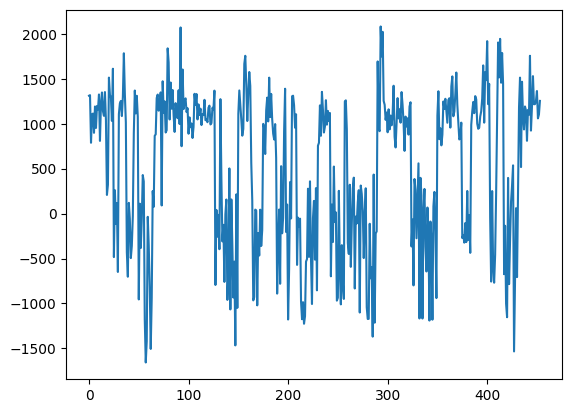

In [6]:
# Here we can plot such a series.
plt.plot(data["time"][data["series"] == 0],
         data["y"][data["series"] == 0])
plt.show()

## Model

In [7]:
# Now we can try and recover the simulated latent states and the functional relationships between x,z and y for each of those states. The model is again specified by
# means of a formula (for the GAMM) and a PFormula (for the state duration distributions, see IR GAMM). For this model we allow for the relationship between x and y to
# differ not just per latent state but also per level of factor cond (see the by argument)! The relationship between z and y only differs per latent state. We also add a
# random intercept term - the smoothing penalty (related to the variance of the random effect; see Wood, 2017) is allowed to differ per latent state. We tell the model
# to try and recover 3 latent states.
formula = Formula(lhs("y"),
                  [i(),
                   f(["x"],nk=10,by="cond"),
                   f(["z"],nk=10),
                   ri("series")],
                   n_j=3,
                   data=data,
                   split_scale=True,
                   series_id="series")

# The Pformula holds a sojourn time distribution for each of the n_j=3 states. See IR GAMM for details. Here we again allow for different distribution parameters to be
# estimated per latent stage.
pformula = PFormula([PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond"),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0},split_by="cond")])

model = sMsGAMM(formula,Gaussian(),pformula,t_endpoints,cpus=4)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:311: UserWarning: split_scale==True! All terms will be estimted per latent stage, independent of terms' by_latent status.
  warnings.warn("split_scale==True! All terms will be estimted per latent stage, independent of terms' by_latent status.")


In [8]:
# We fit the model to convergence.
llk_hist,states = model.fit(max_no_improv=50)

Converged 67


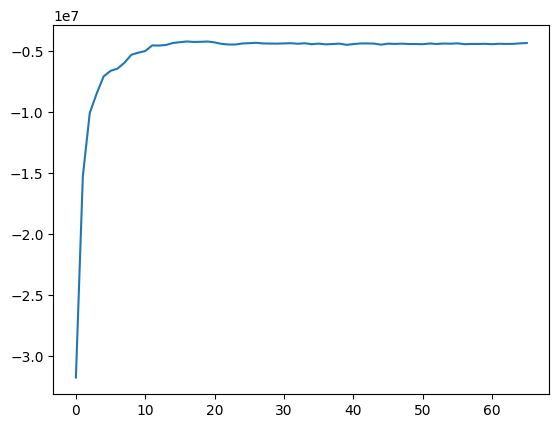

In [9]:
# We can again visualize Convergence
plt.plot(llk_hist)
plt.show()

## Parameter inspection

In [10]:
# We can again get the best parameters. state_coef and state_scale hold the coefficient set and scale parameter estimated for each of the n_j states
state_coef,state_scales,TR,pi = model.get_pars()

In [11]:
# First 20 coefficients associated with first state
state_coef[0][:20]

array([1165.4245071 ,   -5.65443238,   18.11661659,   25.38981996,
         13.64757906,   -5.42805272,  -21.49769186,  -21.24069745,
         22.79654282,  109.643003  ,  203.07166854,   30.84601048,
          7.10549452,   -9.14376591,  -21.8298238 ,  -30.1208174 ,
        -34.90132812,  -36.5965119 ,  -34.84687732,  -23.87472894])

In [12]:
# Recovered scale parameters per state
state_scales

[75823.99220683906, 22169.02988635084, 70221.90069619214]

In [13]:
# pi and TR hold the initial state distribution and state transition matrix respectively (see Yu, 2011)
print(pi) # Probability of being in state j at first time-point
print(TR) # Probability of changing from state j to i == TR[j,i]

[0.85 0.15 0.  ]
[[0.         0.38679245 0.61320755]
 [0.6744186  0.         0.3255814 ]
 [0.76029056 0.23970944 0.        ]]


[[2.         0.         4.26901408]
 [2.         0.         3.40807175]]


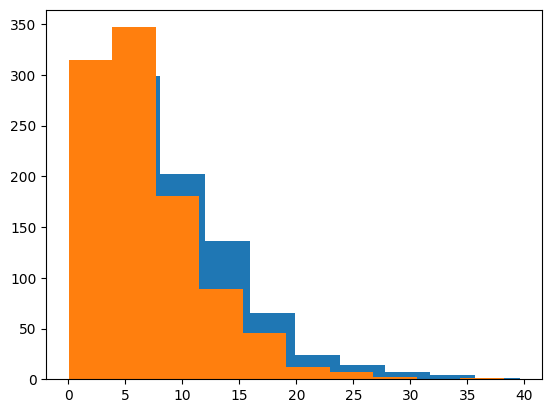

[[2.         0.         6.28571429]
 [2.         0.         7.9965035 ]]


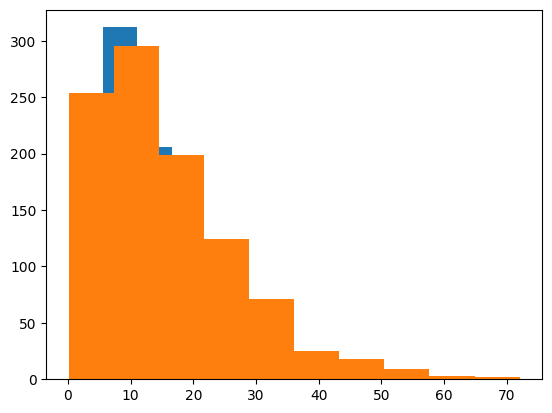

[[2.         0.         2.84960938]
 [2.         0.         2.35106383]]


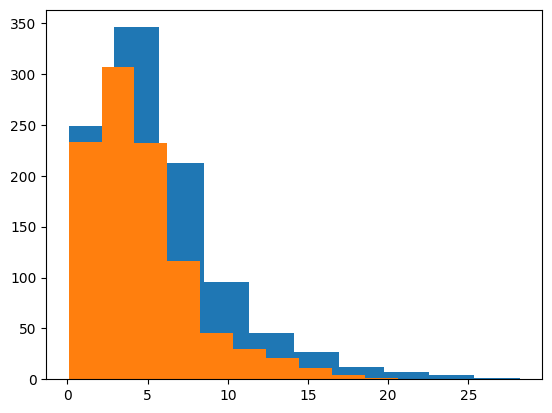

In [14]:
# Similar to the IR GAMM we can look at the sojourn time distributions estimated for different states and conditions.
Pterms = model.pds
for pdj in Pterms:
    print(pdj.params)
    # We can sample from a Gamma distribution using these parameters
    # to get an estimate of the density.
    sample = scp.stats.gamma.rvs(*pdj.params[0,:],size=1000)
    plt.hist(sample)
    # pd.params[1,:] holds te params for group b.
    sample_b = scp.stats.gamma.rvs(*pdj.params[1,:],size=1000)
    plt.hist(sample_b)
    plt.show()

## State sequences

In [15]:
# We can assign the recovered state sequences to the data and then compare those to the ground truth.
data["state_est"] = states # ToDo: These could probably benefit from global decoding using the final parameters..

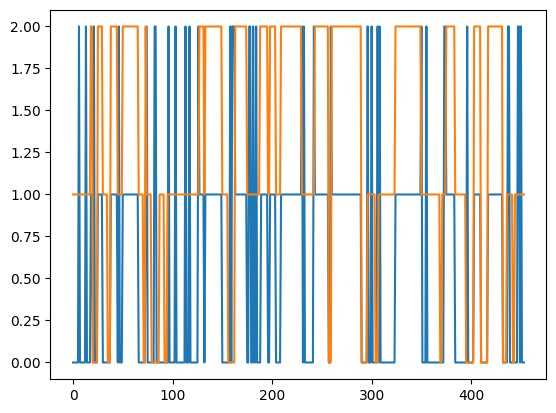

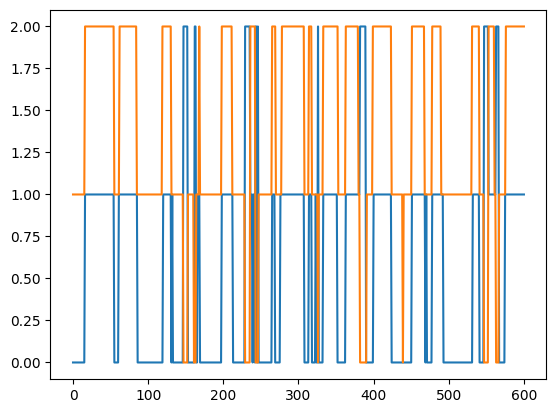

In [16]:
# Plot recovered series vs. true series of states.
# Note that the rows of the recovered state transition matrix might not match the
# rows of the actual transition matrix - so a state of 0 in the original transition matrix might be
# the second recovered state.
for s in np.unique(data["series"])[0:2]:
    plt.plot(data["time"][data["series"] == s],
            data["state_est"][data["series"] == s])
    plt.plot(data["time"][data["series"] == s],
             data["true_states"][data["series"] == s])
    plt.show()

## Visualization

Of particular interest are the functional relationships between the predictors (x,z) and the dependent variable per state. Below we can visualize the recovered functions f(x) per state and condition and the recovered functions f(z) per state.

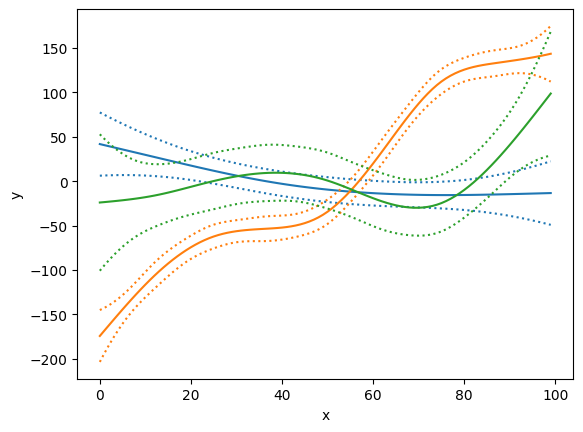

In [19]:
# Prediction for effect of x for all states
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

for si in range(3):
    # Set up some new data for prediction
    x_pred = [v for v in range(0,100,1)]
    z_pred = [v for v in range(100,200,1)]
    new_dat = pd.DataFrame({"x":x_pred,
                            "z":z_pred,
                            "cond":["b" for _ in range(len(x_pred))],
                            "series":[0 for _ in range(len(x_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,b = model.predict(si,[1],new_dat,ci=True,alpha=0.05)
    plt.plot(x_pred,pred,color=colors[si])
    plt.plot(x_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(x_pred,pred-b,color=colors[si], linestyle='dotted')

plt.xlabel("x")
plt.ylabel("y")
plt.show()

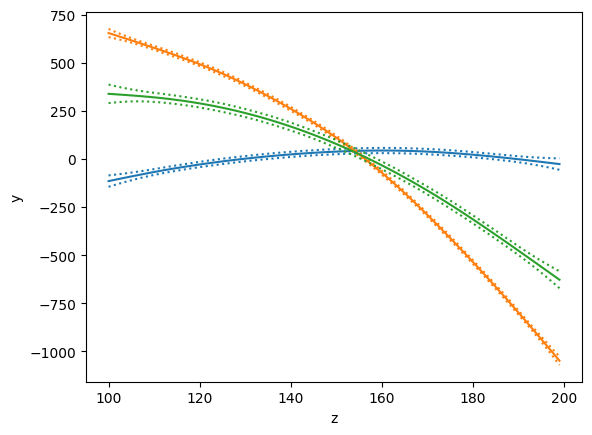

In [18]:
# Prediction for effect of z for all states
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

for si in range(3):
    # Set up some new data for prediction
    x_pred = [v for v in range(0,100,1)]
    z_pred = [v for v in range(100,200,1)]
    new_dat = pd.DataFrame({"x":x_pred,
                            "z":z_pred,
                            "cond":["b" for _ in range(len(x_pred))],
                            "series":[0 for _ in range(len(x_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,b = model.predict(si,[2],new_dat,ci=True,alpha=0.05)
    plt.plot(z_pred,pred,color=colors[si])
    plt.plot(z_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(z_pred,pred-b,color=colors[si], linestyle='dotted')

plt.xlabel("z")
plt.ylabel("y")
plt.show()